In [1]:
import pickle
all_preds=pickle.load(open('all_predictions.p','rb'))

tests_by_century = {'21': ['ned.testb'],
                   '19': ['test_RHC.txt','test_NHA.txt'],
                   '17-18': ['test_VOC.txt','test_SA.txt']}

In [23]:
label_list = ['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O']
id2label_original = {i: label for i, label in enumerate(label_list)}
id2label = id2label_original

In [17]:
import numpy as np

def clean_predictions(preds):
    predictions = np.argmax(preds.predictions, axis=2)
    labels = preds.label_ids

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label_original[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    return true_predictions, true_labels

In [75]:
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report

def compute_metrics(eval_prediction):
#     print(id2label)
    true_predictions, true_labels = eval_prediction#clean_predictions(eval_prediction)
    return {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
        "classification_report": classification_report(true_labels, true_predictions),
    }

In [76]:
def flatten(stuff):
    return [item for entry in stuff for item in entry]

In [77]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
model_names = {'GysBERT': "/ivi/ilps/personal/vprovat/KB/models/GysBERT-NER-v2",
              'BERTje': "/ivi/ilps/personal/vprovat/KB/models/BERTje-NER-v2",
              'BERT-multi-cased': "/ivi/ilps/personal/vprovat/KB/models/BERT-multi-cased-NER-v2",
              'WikiNEuRal': "Babelscape/wikineural-multilingual-ner"}
# model = AutoModelForTokenClassification.from_pretrained(model_names['WikiNEuRal']) # just to get the labels for WikiNEuRal
# id2label = model.config.id2label

In [78]:
def scores_by_century(model_name, century):
    global id2label
    if model_name == 'WikiNEuRal':
        loaded_model = AutoModelForTokenClassification.from_pretrained(model_names['WikiNEuRal'])
        id2label = loaded_model.config.id2label
    else:
        id2label = id2label_original
        
    total_preds = []
    total_labels = []
    for test in tests_by_century[century]:
        cur_preds, cur_labels = clean_predictions(all_preds[model_name][test])
        total_preds.extend(cur_preds)
        total_labels.extend(cur_labels)
        
    return compute_metrics((total_preds, total_labels))

In [79]:
res = scores_by_century('WikiNEuRal','21')

/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
res['classification_report']

'              precision    recall  f1-score   support\n\n         LOC       0.72      0.90      0.80       753\n        MISC       0.00      0.00      0.00         0\n         ORG       0.00      0.00      0.00         0\n         PER       0.94      0.86      0.90      1072\n\n   micro avg       0.31      0.88      0.46      1825\n   macro avg       0.42      0.44      0.42      1825\nweighted avg       0.85      0.88      0.86      1825\n'

In [61]:
def extract_p_r(report, label):
    for line in report.split('\n'):
        if line.strip().startswith(label):
#             print(line, line.split())
            p, r = line.split()[1],line.split()[2]
            return float(p), float(r)

In [62]:
# import pandas as pd

In [63]:
# from io import StringIO  

# csvStringIO = StringIO(res['classification_report'].replace('\n\n','\n'))
# report = pd.read_csv(csvStringIO,sep='\t', names=['precision','recall','f1-score','support'])

In [64]:
extract_p_r(res['classification_report'], 'LOC')

         LOC       0.72      0.90      0.80       753 ['LOC', '0.72', '0.90', '0.80', '753']


(0.72, 0.9)

In [80]:
records = []
for model_name in model_names:
    for century in tests_by_century:
        report = scores_by_century(model_name,century)['classification_report']
        
        p_loc, r_loc = extract_p_r(report,'LOC')
        p_per, r_per = extract_p_r(report, 'PER')
        records.append({'model_name': model_name,
                       'century': century,
                        'type': 'P_LOC',
                        'number': p_loc
                       })
        records.append({'model_name': model_name,
                       'century': century,
                        'type': 'R_LOC',
                        'number': r_loc
                       })
        records.append({'model_name': model_name,
                       'century': century,
                        'type': 'P_PER',
                        'number': p_per
                       })
        records.append({'model_name': model_name,
                       'century': century,
                        'type': 'R_PER',
                        'number': r_per
                       })

/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


         LOC       0.72      0.66      0.69       751 ['LOC', '0.72', '0.66', '0.69', '751']
         PER       0.74      0.76      0.75      1070 ['PER', '0.74', '0.76', '0.75', '1070']
         LOC       0.81      0.77      0.79       269 ['LOC', '0.81', '0.77', '0.79', '269']
         PER       0.76      0.73      0.74       379 ['PER', '0.76', '0.73', '0.74', '379']
         LOC       0.74      0.79      0.76       566 ['LOC', '0.74', '0.79', '0.76', '566']
         PER       0.71      0.67      0.69      1067 ['PER', '0.71', '0.67', '0.69', '1067']


/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


         LOC       0.71      0.71      0.71       752 ['LOC', '0.71', '0.71', '0.71', '752']
         PER       0.88      0.83      0.85      1071 ['PER', '0.88', '0.83', '0.85', '1071']
         LOC       0.78      0.77      0.78       269 ['LOC', '0.78', '0.77', '0.78', '269']
         PER       0.80      0.73      0.76       377 ['PER', '0.80', '0.73', '0.76', '377']
         LOC       0.77      0.78      0.78       562 ['LOC', '0.77', '0.78', '0.78', '562']
         PER       0.76      0.71      0.73      1051 ['PER', '0.76', '0.71', '0.73', '1051']


/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


         LOC       0.51      0.48      0.50       750 ['LOC', '0.51', '0.48', '0.50', '750']
         PER       0.74      0.71      0.72      1069 ['PER', '0.74', '0.71', '0.72', '1069']
         LOC       0.81      0.75      0.78       253 ['LOC', '0.81', '0.75', '0.78', '253']
         PER       0.77      0.72      0.74       360 ['PER', '0.77', '0.72', '0.74', '360']
         LOC       0.79      0.77      0.78       552 ['LOC', '0.79', '0.77', '0.78', '552']
         PER       0.72      0.68      0.70       994 ['PER', '0.72', '0.68', '0.70', '994']


/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


         LOC       0.72      0.90      0.80       753 ['LOC', '0.72', '0.90', '0.80', '753']
         PER       0.94      0.86      0.90      1072 ['PER', '0.94', '0.86', '0.90', '1072']


/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: Und

         LOC       0.50      0.48      0.49       269 ['LOC', '0.50', '0.48', '0.49', '269']
         PER       0.61      0.45      0.51       377 ['PER', '0.61', '0.45', '0.51', '377']


/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: Und

         LOC       0.48      0.50      0.49       565 ['LOC', '0.48', '0.50', '0.49', '565']
         PER       0.48      0.40      0.43      1060 ['PER', '0.48', '0.40', '0.43', '1060']


/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
df = pd.DataFrame.from_records(records)

In [82]:
df

,model_name,century,type,number
0,GysBERT,21,P_LOC,0.72
1,GysBERT,21,R_LOC,0.66
2,GysBERT,21,P_PER,0.74
3,GysBERT,21,R_PER,0.76
4,GysBERT,19,P_LOC,0.81
5,GysBERT,19,R_LOC,0.77
6,GysBERT,19,P_PER,0.76
7,GysBERT,19,R_PER,0.73
8,GysBERT,17-18,P_LOC,0.74
9,GysBERT,17-18,R_LOC,0.79


In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_palette('Set2')

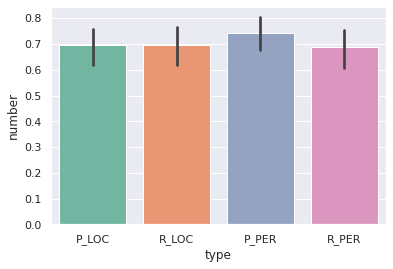

In [83]:
sns.barplot(x="type", y="number", data=df)

/home/vprovat/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/vprovat/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

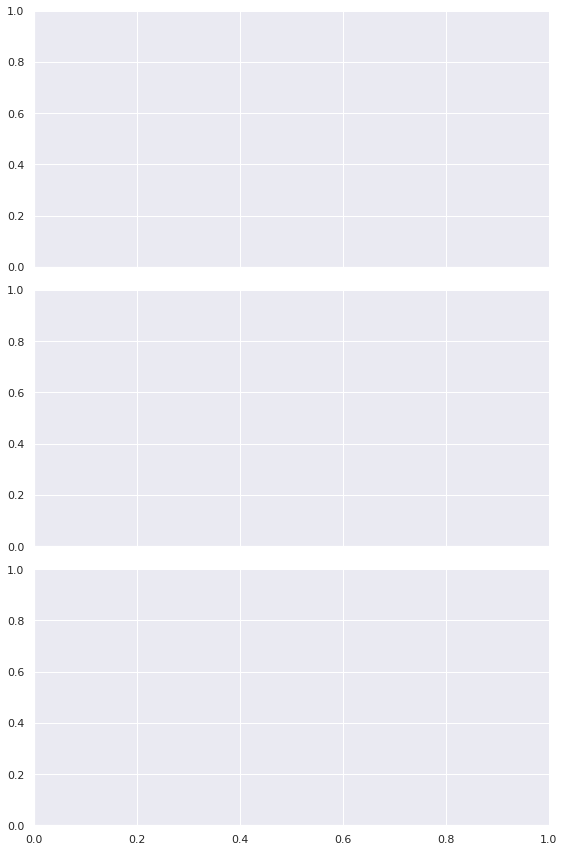

In [88]:
g = sns.FacetGrid(df, row="century",hue='model_name',size=4, aspect=2)
g.map(sns.barplot, x='type', y='number')